#load the dataset

In [0]:
import os
import json
import gzip
import pandas as pd
import numpy as np
from urllib.request import urlopen
from sklearn.feature_extraction import DictVectorizer

In [0]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz

--2020-04-14 19:42:11--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Cell_Phones_and_Accessories_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169071325 (161M) [application/octet-stream]
Saving to: ‘Cell_Phones_and_Accessories_5.json.gz’

Cell_Phones_and_Acc 100%[===================>] 161.24M  8.80MB/s    in 19s     

2020-04-14 19:42:31 (8.38 MB/s) - ‘Cell_Phones_and_Accessories_5.json.gz’ saved [169071325/169071325]



In [0]:
data = []
with gzip.open('Cell_Phones_and_Accessories_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
# convert list into pandas dataframe
df = pd.DataFrame.from_dict(data)    
# total length of list, this number equals total number of products
print(len(data))

1128437


# use the small dataset - influencers

In [0]:
influencers = pd.read_csv('/content/influencers.csv')
influencers.head(3)

,reviewTime,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,image,avgVote,influencer,Year,Month,Weekday
0,2016-07-14,4.0,1,A22QN0P5ERNOKR,B01F9N5QXI,Paul M.,"<div id=""video-block-R1K03IBUILYEB0"" class=""a-...","The only thing ""cheap"" about this budget smart...",1468454400,1,782.0,1,2016,7,3
1,2015-08-21,5.0,0,AQJ824C2JST96,B00X5RV14Y,Gladius,Anker PowerCore 20100 Review by a Frequent Fl...,Anker PowerCore 20100 Review by a Frequent Fl...,1440115200,0,653.0,1,2015,8,4
2,2016-02-05,5.0,1,A1BDNTBJ0JWXSL,B019O8YWXE,Wilfred,OVERVIEW\nThe Huawei Honor 5x is the first of ...,The first real budget phone thats worth the money,1454630400,1,530.0,1,2016,2,4


In [0]:
review = influencers.loc[:,['reviewText']]
# create the label
review["is_bad_review"] = influencers["overall"].apply(lambda x: 1 if x < 3.5 else 0)
review.head()

,reviewText,is_bad_review
0,"<div id=""video-block-R1K03IBUILYEB0"" class=""a-...",0
1,Anker PowerCore 20100 Review by a Frequent Fl...,0
2,OVERVIEW\nThe Huawei Honor 5x is the first of ...,0
3,This review will touch quickly on the internal...,0
4,"We've all seen the ads for Jitterbug phones, a...",0


In [0]:
influencers['is_bad_review'] = review['is_bad_review']

In [0]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
influencers["review_clean"] = influencers["reviewText"].apply(lambda x: clean_text(x))

In [0]:
influencers.head(3)

,reviewTime,overall,verified,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,image,avgVote,influencer,Year,Month,Weekday,is_bad_review,review_clean
0,2016-07-14,4.0,1,A22QN0P5ERNOKR,B01F9N5QXI,Paul M.,"<div id=""video-block-R1K03IBUILYEB0"" class=""a-...","The only thing ""cheap"" about this budget smart...",1468454400,1,782.0,1,2016,7,3,0,"div class=""a-section a-spacing-small a-spacing..."
1,2015-08-21,5.0,0,AQJ824C2JST96,B00X5RV14Y,Gladius,Anker PowerCore 20100 Review by a Frequent Fl...,Anker PowerCore 20100 Review by a Frequent Fl...,1440115200,0,653.0,1,2015,8,4,0,anker powercore review frequent flyer business...
2,2016-02-05,5.0,1,A1BDNTBJ0JWXSL,B019O8YWXE,Wilfred,OVERVIEW\nThe Huawei Honor 5x is the first of ...,The first real budget phone thats worth the money,1454630400,1,530.0,1,2016,2,4,0,overview\nthe huawei honor first kind game cha...


## feature engineering

We first start by adding sentiment analysis features because we can guess that customers reviews are highly linked to how they felt about their stay at the hotel. We use Vader, which is a part of the NLTK module designed for sentiment analysis. Vader uses a lexicon of words to find which ones are positives or negatives. It also takes into account the context of the sentences to determine the sentiment scores. For each text, Vader returns 4 values:
a neutrality score
a positivity score
a negativity score
an overall score that summarizes the previous scores
We will integrate those 4 values as features in our dataset.

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
influencers["sentiments"] = influencers["reviewText"].apply(lambda x: sid.polarity_scores(x))
influencers = pd.concat([influencers.drop(['sentiments'], axis=1), influencers['sentiments'].apply(pd.Series)], axis=1)

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Next, we add some simple metrics for every text:
number of characters in the text
number of words in the text

In [0]:
# add number of characters column
influencers["nb_chars"] = influencers["reviewText"].apply(lambda x: len(x))

# add number of words column
influencers["nb_words"] = influencers["reviewText"].apply(lambda x: len(x.split(" ")))

The next step consist in extracting vector representations for every review. The module Gensim creates a numerical vector representation of every word in the corpus by using the contexts in which they appear (Word2Vec). This is performed using shallow neural networks. What’s interesting is that similar words will have similar representation vectors.
Each text can also be transformed into numerical vectors using the word vectors (Doc2Vec). Same texts will also have similar representations and that is why we can use those vectors as training features.
We first have to train a Doc2Vec model by feeding in our text data. By applying this model on our reviews, we can get those representation vectors.

In [0]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(influencers["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = influencers["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
influencers = pd.concat([influencers, doc2vec_df], axis=1)

Finally we add the TF-IDF (Term Frequency — Inverse Document Frequency) values for every word and every document.
The TF-IDF metric solves this problem:
TF computes the classic number of times the word appears in the text
IDF computes the relative importance of this word which depends on how many texts the word can be found
We add TF-IDF columns for every word that appear in at least 10 different texts to filter some of them and reduce the size of the final output.

In [0]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(influencers["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = influencers.index
influencers = pd.concat([influencers, tfidf_df], axis=1)

In [0]:
# influencers.to_csv('influencers_combined.csv', index=False)

## Exploratory data

In order to have a better understanding of our data, let’s explore it a little:

In [0]:
# show is_bad_review distribution
influencers["is_bad_review"].value_counts(normalize = True)

0    0.81
1    0.19
Name: is_bad_review, dtype: float64

In [0]:
# highest positive sentiment reviews (with more than 5 words)
influencers[influencers["nb_words"] >= 5].sort_values("pos", ascending = False)[["review_clean", "pos","influencer"]].head(10)

,review_clean,pos,influencer
823,nicely build elegant good fit,0.919,0
572,fit perfectly protect well look good,0.852,0
893,good product good price good service,0.744,0
876,excellent packaging awesome look,0.722,0
917,great product nice price,0.697,0
739,beautiful product compact efficient functional,0.691,0
880,cool work great,0.690,0
743,love fun phone super durable,0.661,0
699,great prop easy put away,0.646,0
796,good price quick ship work great,0.636,0


Need explain for the above result

In [0]:
# lowest negative sentiment reviews (with more than 5 words)
influencers[influencers["nb_words"] >= 5].sort_values("neg", ascending = False)[["review_clean", "neg","influencer"]].head(10)

,review_clean,neg,influencer
929,suck waste money,0.655,0
517,screen go bad within day,0.467,0
978,absolutly horrible week use stop work stop rea...,0.456,0
524,super product problem,0.415,0
672,holster clip break real quick,0.412,0
706,week start fall apart quality suck,0.386,0
904,break first time drop phone,0.359,0
642,long hands-free,0.355,0
790,get disgust even return refund phone still bra...,0.329,0
841,place lexus yet,0.306,0


Need explain for the above result

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


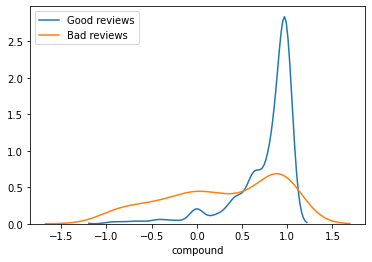

In [0]:
# plot sentiment distribution for positive and negative reviews
import seaborn as sns

for x in [0, 1]:
    subset = influencers[influencers['is_bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

The above graph shows the distribution of the reviews sentiments among good reviews and bad ones. We can see that good reviews are for most of them considered as very positive by Vader. Need to explain

## RF model - need to explain

We first choose which features we want to use to train our model. Then we split our data into two parts:
one to train our model
one to assess its performances
We will next use a Random Forest (RF) classifier for our predictions.

In [0]:
# feature selection
label = "is_bad_review"
ignore_cols = [label, "reviewText", "review_clean","reviewTime","Year","Month","Weekday","reviewerID","asin","reviewerName","summary","unixReviewTime","image","overall","verified","influencer","avgVote"]
features = [c for c in influencers.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(influencers[features], influencers[label], test_size = 0.20, random_state = 42)

In [0]:
influencers[features].head(3)

,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4,word_ability,word_able,word_absolutely,word_ac,word_accept,word_acceptable,word_access,word_accessible,word_accessory,word_accidentally,word_accord,word_account,word_accurate,word_across,word_act,word_action,word_activate,word_active,word_actual,word_actually,word_adapter,word_add,word_added,word_addition,word_additional,word_additionally,word_address,word_adequate,word_adhesive,...,word_whole,word_why,word_wi,word_wide,word_widget,word_wife,word_wifi,word_willing,word_window,word_windows,word_winner,word_wipe,word_wire,word_wireless,word_wish,word_with,word_within,word_without,word_wonder,word_wonderful,word_word,word_work,word_works,word_world,word_worry,word_worth,word_would,word_wow,word_wrap,word_wrist,word_write,word_wrong,word_yeah,word_year,word_yes,word_yet,word_you,word_youtube,word_zero,word_zoom
0,0.080,0.779,0.141,0.9874,3387,574,0.040447,2.036505,1.467552,0.749308,1.296132,0.0,0.034202,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.053799,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.052096,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032577,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.073021,0.0,0.0,0.0,0.0,0.047848,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.011,0.829,0.160,0.9993,5203,862,1.335943,1.413918,4.011773,0.302718,1.429320,0.0,0.024242,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.114397,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.024183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.031969,0.0,0.034945,0.0,0.0,0.051757,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.028986,0.000000,0.0,0.0,0.0,0.0
2,0.050,0.797,0.153,0.9986,4910,872,0.461013,2.755375,2.289742,1.045264,1.759157,0.0,0.024490,0.0,0.0,0.0,0.0,0.032507,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.042189,0.0,0.0,0.0,0.025707,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.041691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046654,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.174291,0.0,0.0,0.0,0.0,0.000000,0.0,0.024732,0.000000,0.028666,0.0,0.0,0.0,0.0


In [0]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
3,compound,0.051298
2,pos,0.034049
0,neg,0.024790
1,neu,0.016114
7,doc2vec_vector_1,0.013271
8,doc2vec_vector_2,0.012753
10,doc2vec_vector_4,0.012254
9,doc2vec_vector_3,0.011036
4,nb_chars,0.010264
1237,word_return,0.009620


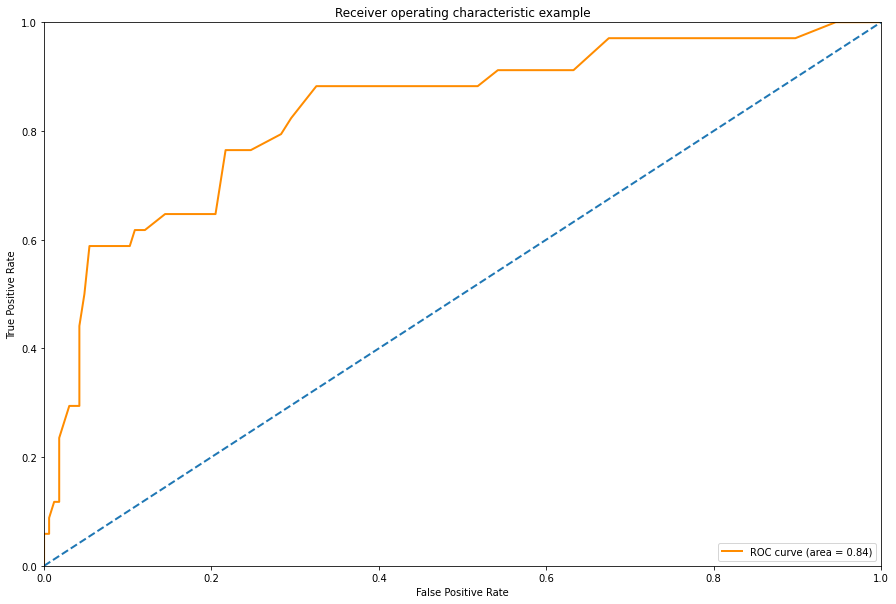

In [0]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

The ROC (Receiver Operating Characteristic) curve is usually a good graph to summarize the quality of our classifier. The higher the curve is above the diagonal baseline, the better the predictions. Although the AUC ROC (Area Under the Curve ROC) is very good, we should not use here the ROC curve to assess the quality of our model.
Why? First let us remind the False Positive Rate formula, which corresponds to the x axis of the ROC curve: FPR (False Positive Rate) = # False Positives / # Negatives.
Here the # Negatives corresponds to our number of good reviews which is very high because our dataset is imbalanced. This means that even with some False Positives, our FPR will tend to stay very low. Our model will be able to make a lot of false positives predictions and still have a low false positive rate, while increasing the true positive rate and therefore artificially increasing the AUC ROC metric.

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.57')

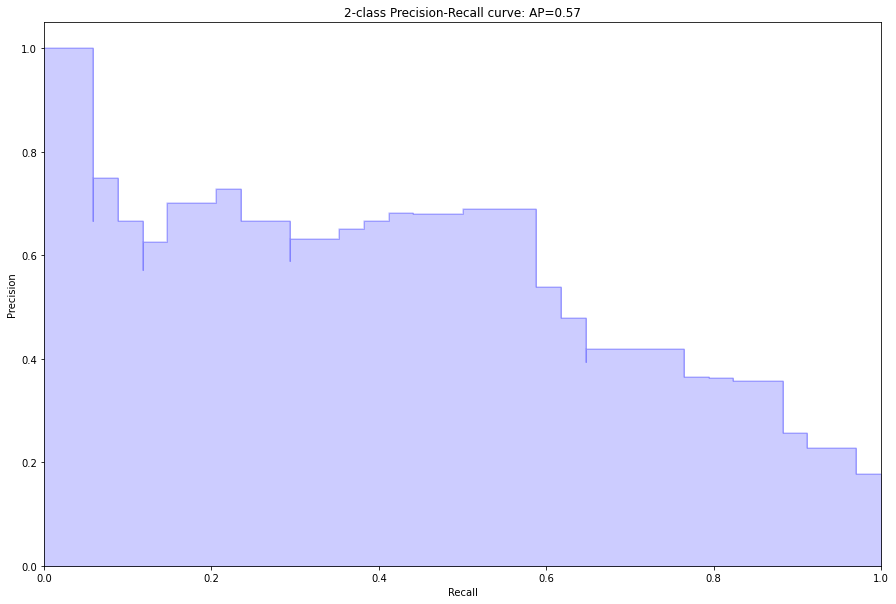

In [0]:
# PR curve

from sklearn.metrics import average_precision_score, precision_recall_curve
# from sklearn.utils.fixes import signature
from inspect import signature

average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

A better metric in this imbalanced situation is the AUC PR (Area Under the Curve Precision Recall), or also called AP (Average Precision).
We can see that the precision decreases when we increase the recall. This shows us that we have to choose a prediction thresold adapted to our needs. If our goal is to have a high recall, we should set a low prediction thresold that will allow us to detect most of the observations of the positive class, but with a low precision. On the contrary, if we want to be really confident about our predictions but don’t mind about not finding all the positive observations, we should set a high thresold that will get us a high precision and a low recall.
In order to know if our model performs better than another classifier, we can simply use the AP metric. To assess the quality of our model, we can compare it to a simple decision baseline. Let’s take a random classifier as a baseline here that would predict half of the time 1 and half of the time 0 for the label.
Such a classifier would have a precision of 4.3%, which corresponds to the proportion of positive observations. For every recall value the precision would stay the same, and this would lead us to an AP of 0.043. The AP of our model is approximately 0.35, which is more than 8 times higher than the AP of the random method. This means that our model has a good predictive power.

# DO NOT USE - preposscessing the dataset

In [0]:
df = df.fillna('')
df['reviewTime'] = pd.to_datetime(df['reviewTime'], format ='%m %d, %Y')

In [0]:
review = df.loc[:,['reviewText']]
# create the label
review["is_bad_review"] = df["overall"].apply(lambda x: 1 if x < 3.5 else 0)
review.head()

,reviewText,is_bad_review
0,Looks even better in person. Be careful to not...,0
1,When you don't want to spend a whole lot of ca...,0
2,"so the case came on time, i love the design. I...",1
3,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,1
4,"I liked it because it was cute, but the studs ...",0


## have a small dataset

In [0]:
#We sample the data in order to speed up computations.
reviews_df = review.sample(frac = 0.1, replace = False, random_state=45)

In [0]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["review_clean"] = reviews_df["reviewText"].apply(lambda x: clean_text(x))

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["reviewText"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["reviewText"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["reviewText"].apply(lambda x: len(x.split(" ")))

In [0]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)


In [0]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [0]:
# show is_bad_review distribution
reviews_df["is_bad_review"].value_counts(normalize = True)

0    0.79056
1    0.20944
Name: is_bad_review, dtype: float64

Our dataset is little imbalanced because only 20% of our reviews are considered as negative ones. This information will be very useful for the modelling part.

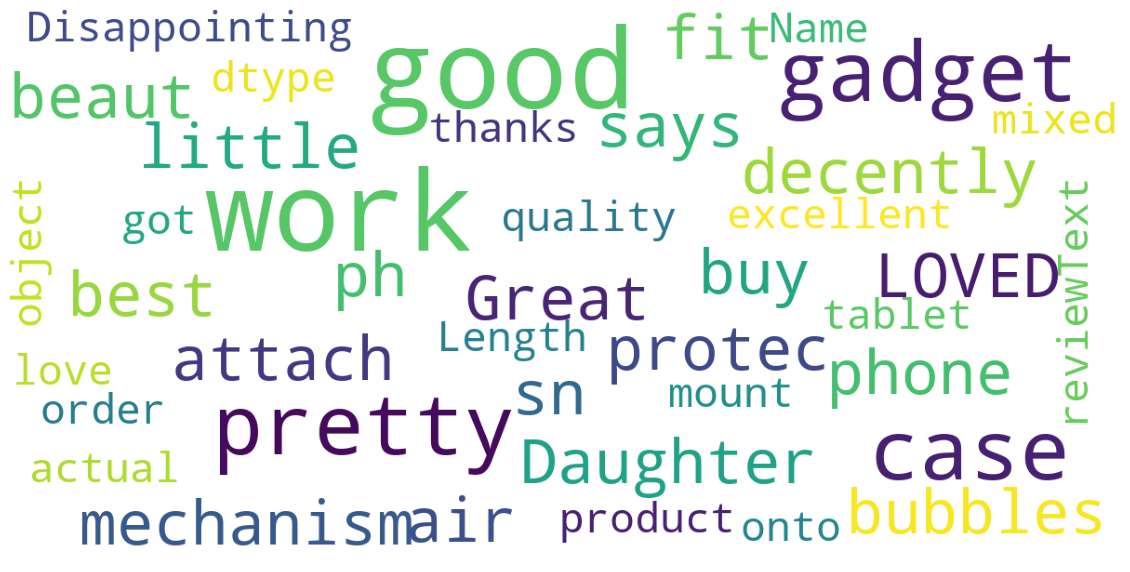

In [0]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["reviewText"])

In [0]:
# highest positive sentiment reviews (with more than 5 words)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["reviewText", "pos"]].head(10)